In [7]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics.pairwise import euclidean_distances
from sklearn.model_selection import train_test_split


from scipy import optimize
from scipy.io import loadmat

import numba 
from numba import prange

from scipy.io import savemat

from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=1)


d = loadmat('data/macosko.mat')

X_data = d['X_data']
y_data = d['y_data'].reshape(-1)

print(X_data.shape,y_data)

#X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=.33, random_state=42)

X_train = X_data
y_train = y_data

n = X_train.shape[0]

classes = ['Amacrine cells',
           'Astrocytes',
           'Bipolar cells',
           'Cones',
           'Fibroblasts',
           'Horizontal cells',
           'Microglia',
           'Muller glia',
           'Pericytes',
           'Retinal ganglion cells',
           'Rods',
           'Vascular endothelium']
    
print(X_train.shape, y_train.shape, X_train.dtype)
#print(X_test.shape, y_test.shape, X_test.dtype)

epochs = 200
n_neighbors= 30
n_components = 2
MIN_DIST = 0.1
neg_sample_rate = 1.0
    
%matplotlib notebook

%load_ext autoreload
%autoreload 2

(44808, 50) [ 9.  9.  9. ...  9. 10. 10.]
(44808, 50) (44808,) float32
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
np.random.seed(23423)

rand_perm = np.random.permutation(n)

X_train_rp = X_train[rand_perm]
y_train_rp = y_train[rand_perm]

nA = 3008
nRest = 8360


SETA = X_train_rp[:nA]
y_SETA = y_train_rp[:nA]

SETS = []
y_SETS = []
DATA = []

N_DATA = []

for i in range(5):
    pass
    print('in loop')
    
    setb = X_train_rp[nA+nRest*i:nA+nRest*(i+1)]
    y_setb = y_train_rp[nA+nRest*i:nA+nRest*(i+1)]
    data = np.concatenate((SETA,setb))
    N_DATA.append(data.shape[0])
    
    SETS.append(setb)
    y_SETS.append(y_setb)
    DATA.append(data)

    
print('out of loop')    

SETS = np.array(SETS)
DATA = np.array(DATA)
N_DATA = np.array(N_DATA)

n_SET = SETS.shape[0]

print(SETA.shape, SETS.shape, SETS[0].shape, DATA.shape, n_SET)

in loop
in loop
in loop
in loop
in loop
out of loop
(3008, 50) (5, 8360, 50) (8360, 50) (5, 11368, 50) 5


In [11]:
import numpy as np

import numba
from numba import prange

import random

import scipy.sparse

import gc


@numba.jit(nopython=True, parallel=True)
def euclidean_distances_numba(X, squared = True):
    n = X.shape[0]
    xcorr = np.zeros((n,n),dtype=X.dtype)
    for i in prange(n):
        for j in range(i,n):
            dist = np.sum( np.square(X[i,:] - X[j,:]) )
            if not squared:
                dist = np.sqrt(dist)
            xcorr[i,j] = dist
            xcorr[j,i] = dist
    
    return xcorr

#@numba.jit(nopython=True)
def get_weight_function(dists, rho, sigma):
    d = dists - rho
    #print(d)
    d[d<0] = 0
    weight = np.exp(- d / sigma )
    return weight

#@numba.jit(nopython=True)
def search_sigma(dists, rho, k, tol = 10**-5, n_iteration=200):
    sigma_min = 0
    sigma_max = 1000
    
    cur_sigma = 100
    
    logk = np.log2(k)
    #print(logk)
    
    for i in range(n_iteration):
        
        cur_sigma = (sigma_min+sigma_max)/2
        probs = get_weight_function(dists,rho,cur_sigma)
        weight = np.sum(probs)
        #print(weight)
        
        if np.abs(logk - weight) < tol:
            break
        
        if weight < logk:
            sigma_min = cur_sigma
        else:
            sigma_max = cur_sigma
        
    return cur_sigma, probs

@numba.jit(nopython=True, parallel=True)
def symmetrization_step(prob):
    n = prob.shape[0]
    P = np.zeros((n,n),dtype=np.float32)

    for i in prange(n):
        #if i%1000 == 0:
        #    print('Completed ', i, ' of ', n)
        for j in prange(i,n):
            p = prob[i,j] + prob[j,i] - prob[i,j] * prob[j,i] #t-conorm
            P[i,j] = p
            P[j,i] = p
            
    return P

def get_prob_matrix(X, n_neighbors=15):
    n = X.shape[0]
    dist = euclidean_distances_numba(X, squared = False)
    sort_idx = np.argsort(dist,axis=1)
    #sort_idx = sort_idx.astype(np.int32)
    sort_idx = sort_idx[:,1:n_neighbors+1]
    
    rho = [ dist[i, sort_idx[i,0] ] for i in range(n)]
    rho = np.array(rho)
    
    

    sigmas = []

    directed_graph = []


    #'''
    for i in range(n):
        if (i+1)%1000 == 0:
            print('Processed ', i+1, ' of ', n, ' samples.')
        sigma, weights = search_sigma(dists = dist[i,sort_idx[i,:]],rho = rho[i],k = n_neighbors)

        probs = np.zeros(n)
        probs[sort_idx[i,:]] = weights
        #print(sum(weights), np.log2(n_neighbors))
        #print(sort_idx[i,:])
        #print(probs[1770:1780])

        directed_graph.append(probs)

    directed_graph = np.array(directed_graph).astype(np.float32)
    prob = directed_graph
    
    P = symmetrization_step(prob)
    
    graph = scipy.sparse.coo_matrix(P)
    
    return graph

def make_epochs_per_sample(weights, n_epochs):
    """Given a set of weights and number of epochs generate the number of
    epochs per sample for each weight.
    Parameters
    ----------
    weights: array of shape (n_1_simplices)
        The weights ofhow much we wish to sample each 1-simplex.
    n_epochs: int
        The total number of epochs we want to train for.
    Returns
    -------
    An array of number of epochs per sample, one for each 1-simplex.
    Copied from UMAP repo: https://github.com/lmcinnes/umap/
    """
    result = -1.0 * np.ones(weights.shape[0], dtype=np.float64)
    n_samples = n_epochs * (weights / weights.max())
    result[n_samples > 0] = float(n_epochs) / n_samples[n_samples > 0]
    return result
    

In [12]:
GRAPHS = []
ROWS = []
COLUMNS = []
WEIGHTS = []
EPOCHS_PER_SAMPLE = []
EPOCH_OF_NEXT_SAMPLE = []
EPOCHS_PER_NEGATIVE_SAMPLE = []
EPOCH_OF_NEXT_NEGATIVE_SAMPLE = []

SET_IDX = []
K_IDX = []

for iset in range(n_SET):
    graph = get_prob_matrix(DATA[iset],n_neighbors=n_neighbors)
    graph.data[graph.data < (graph.data.max() / float(epochs))] = 0.0
    graph.eliminate_zeros()
    
    epochs_per_sample = make_epochs_per_sample(graph.data, epochs)
    epoch_of_next_sample = epochs_per_sample.copy()
    epochs_per_negative_sample = epochs_per_sample / neg_sample_rate
    epoch_of_next_negative_sample = epochs_per_negative_sample.copy()
    
    set_idx = iset*np.ones(len(epochs_per_sample),dtype=np.int)
    k_idx = np.arange(epochs_per_sample.shape[0],dtype=np.int)
    
    SET_IDX.append(set_idx)
    K_IDX.append(k_idx)
    
    ROWS.append(graph.row)
    COLUMNS.append(graph.col)
    EPOCHS_PER_SAMPLE.append(epochs_per_sample)
    EPOCH_OF_NEXT_SAMPLE.append(epoch_of_next_sample)
    EPOCHS_PER_NEGATIVE_SAMPLE.append(epochs_per_negative_sample)
    EPOCH_OF_NEXT_NEGATIVE_SAMPLE.append(epoch_of_next_negative_sample)
    
    print(epochs_per_sample.shape)
print(SET_IDX)



SET_IDX = np.array(np.concatenate(SET_IDX)).reshape(-1)
K_IDX = np.array(np.concatenate(K_IDX)).reshape(-1)

n_idx = np.random.permutation(len(SET_IDX))
SET_IDX = SET_IDX[n_idx]
K_IDX = K_IDX[n_idx]
    


print('done')

Processed  1000  of  11368  samples.
Processed  2000  of  11368  samples.
Processed  3000  of  11368  samples.
Processed  4000  of  11368  samples.
Processed  5000  of  11368  samples.
Processed  6000  of  11368  samples.
Processed  7000  of  11368  samples.
Processed  8000  of  11368  samples.
Processed  9000  of  11368  samples.
Processed  10000  of  11368  samples.
Processed  11000  of  11368  samples.
(550780,)
Processed  1000  of  11368  samples.
Processed  2000  of  11368  samples.
Processed  3000  of  11368  samples.
Processed  4000  of  11368  samples.
Processed  5000  of  11368  samples.
Processed  6000  of  11368  samples.
Processed  7000  of  11368  samples.
Processed  8000  of  11368  samples.
Processed  9000  of  11368  samples.
Processed  10000  of  11368  samples.
Processed  11000  of  11368  samples.
(550770,)
Processed  1000  of  11368  samples.
Processed  2000  of  11368  samples.
Processed  3000  of  11368  samples.
Processed  4000  of  11368  samples.
Processed  500

In [13]:
SET_IDX

array([2, 0, 2, ..., 3, 1, 0])

Hyperparameters a = 1.576943460405378 and b = 0.8950608781227859


<IPython.core.display.Javascript object>


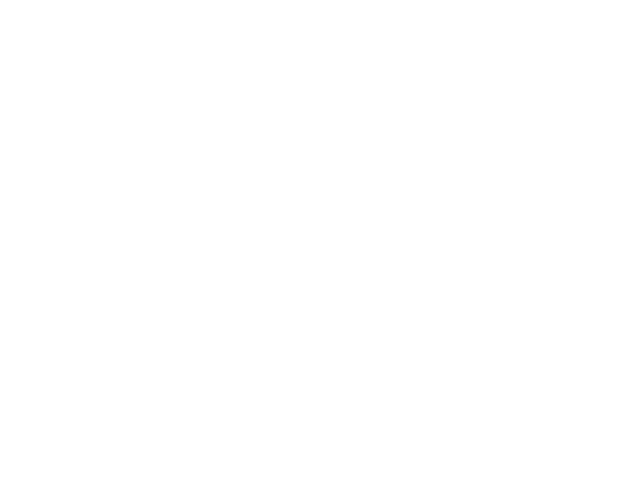

In [14]:
x = np.linspace(0, 3, 300)

y = (x>MIN_DIST) * np.exp(-x+MIN_DIST)
y[x<=MIN_DIST] = 1.0

function = lambda x, a, b: 1 / (1 + a*x**(2*b))

p , _ = optimize.curve_fit(function, x, y) 

a = p[0]
b = p[1] 
print("Hyperparameters a = " + str(a) + " and b = " + str(b))

x_p = np.arange(0,3,0.01)
y_p = np.exp(- (x_p-MIN_DIST) * ( (x_p - MIN_DIST) >=0 ) )
y_p2 = 1 / (1 + a*x_p**(2*b))

plt.figure()
plt.plot(x_p,y_p, label='Target')
plt.plot(x_p,y_p2, label='Fitted')

In [15]:
@numba.jit(nopython=True)
def clip(x,val=4.0):

    if x>val:
        return val
    elif x<-val:
        return -val
    else:
        return x
    
@numba.jit(nopython=True)
def update_attraction(x, y, a, b, dim, lr, P):
    dist = np.sum((x - y)**2)

    if dist>0.0:
        grad_coeff = 2*a*b*dist**(b-1.0) / (1 + a * dist**b)
    else:
        grad_coeff = 0.0


    for d in range(dim):
        mv = clip(grad_coeff * P * (x[0,d]-y[0,d]))  # * P[idx,idy]
        mv = mv * lr

        x[0,d] -= mv
        y[0,d] += mv
        
    return

@numba.jit(nopython=True)
def update_repulsion(x, y, a, b, dim, lr, P):
    dist = np.sum((x - y)**2)

    if dist>0.0:
        grad_coeff = 2 * repulsion_strength * b / ( (0.001+dist) * (1.0 + a * dist**b) )
    else:
        grad_coeff = 0


    for d in range(dim):
        #if grad_coeff > 0.0:
        #    grad = clip(grad_coeff  * (x[0,d]-y[0,d]))
        #    #* (1 - P[idx,idy])
        #else:
        #    grad = 0.0

        grad = clip(grad_coeff  * (x[0,d]-y[0,d]) * (1-P))
        mv = grad * lr

        x[0,d] += mv
        #y[0,d] -= mv

    
    
@numba.jit(nopython=True)
def one_step_in_a_set(emA, emH, idx, rows, columns, a, b, dim,
                   nA, n_points,
                   epochs_per_sample,
                   epoch_of_next_sample,
                   epochs_per_negative_sample,
                   epoch_of_next_negative_sample,
                   lr, epoch):
    
    if epoch_of_next_sample[idx] <= epoch:
        x_idx = rows[idx]
        y_idx = columns[idx]
        
        if x_idx < nA:
            x = emA[x_idx:x_idx+1,:]
        else:
            x = emH[x_idx-nA:x_idx-nA+1,:]
        
        if y_idx < nA:
            y = emA[y_idx:y_idx+1, :]
        else:
            y = emH[y_idx-nA:y_idx-nA+1,:]
            
        update_attraction(x, y, a, b, dim, lr, 1)
        
        epoch_of_next_sample[idx] += epochs_per_sample[idx]
        
        n_neg_samples = int(
                (epoch - epoch_of_next_negative_sample[idx]) / epochs_per_negative_sample[idx]
            )
        
        for i in range(n_neg_samples):
            y_idx = np.random.choice(n_points)
            
            if x_idx == y_idx:
                continue
            
            if y_idx < nA:
                y = emA[y_idx:y_idx+1, :]
            else:
                y = emH[y_idx-nA:y_idx-nA+1,:]
                
            update_repulsion(x, y, a, b, dim, lr, 0)
            
        epoch_of_next_negative_sample[idx] += (
                n_neg_samples * epochs_per_negative_sample[idx]
            )
            
            
            
    
    return 

@numba.jit(nopython=True, parallel=True)
def one_epoch_nsets(emCommon, embS,
                     rows, columns,
                     nCommon, n_points_,
                     Set, K_idx,
                     a, b, dim,
                     lr, epoch,
                     epochs_per_sample,
                     epoch_of_next_sample,
                     epochs_per_negative_sample,
                     epoch_of_next_negative_sample,
                     repulsion_strength=1.0):
    '''
    Set1 = 1 * np.ones(epochs_per_sample_1.shape[0])
    Set2 = 2 * np.ones(epochs_per_sample_2.shape[0])
    Set = np.random.permutation(np.concatenate((Set1,Set2)))
    '''
    
    for i in prange(len(Set)):
        idx = Set[i]
        one_step_in_a_set(emA=emCommon, emH=embS[idx], idx=K_idx[i], 
                              rows=rows[idx], columns=columns[idx], a=a, b=b, dim=dim,
                              nA=nCommon, n_points=n_points_[idx],
                              epochs_per_sample=epochs_per_sample[idx],
                              epoch_of_next_sample=epoch_of_next_sample[idx],
                              epochs_per_negative_sample=epochs_per_negative_sample[idx],
                              epoch_of_next_negative_sample=epoch_of_next_negative_sample[idx],
                              lr=lr, epoch=epoch)
    
    return 

from sklearn.decomposition import PCA

n_components = 2

pca = PCA(n_components = n_components)
init = pca.fit_transform(SETA)
embA = init.astype(np.float32).copy()
expansion = 10.0 / np.abs(embA).max()
embA = (embA * expansion).astype(np.float32)

emb_sets = []

print('before initi')

for i in range(n_SET):
    data = DATA[i]
    emb_i = pca.transform(data[nA:])
    emb_i = (emb_i * expansion).astype(np.float32)
    
    emb_sets.append(emb_i)
    
print('after init')

repulsion_strength=1.0

init_lr = 1.0

#SET_IDX
#K_IDX

print(len(EPOCH_OF_NEXT_NEGATIVE_SAMPLE))
print(EPOCH_OF_NEXT_NEGATIVE_SAMPLE[0].shape)

import timeit

for epoch in range(epochs):
    pass
    
    if epoch%20==0:
        print('epoch ', epoch, 'of ', epochs)
    #print('epoch ', epoch, 'of ', epochs)
    start = timeit.default_timer()
    
    lr = init_lr * (1.0 - float(epoch)/float(epochs))
    
    #'''
    one_epoch_nsets(emCommon=embA, embS=emb_sets,
                     rows=ROWS, columns=COLUMNS,
                     nCommon=nA, n_points_=N_DATA,
                     Set=SET_IDX, K_idx=K_IDX,
                     a=a, b=b, dim=n_components,
                     lr=lr, epoch=epoch,
                     epochs_per_sample=EPOCHS_PER_SAMPLE,
                     epoch_of_next_sample=EPOCH_OF_NEXT_SAMPLE,
                     epochs_per_negative_sample=EPOCHS_PER_NEGATIVE_SAMPLE,
                     epoch_of_next_negative_sample=EPOCH_OF_NEXT_NEGATIVE_SAMPLE,
                     repulsion_strength=repulsion_strength)
    #'''
    stop = timeit.default_timer()
    print('Time for epoch ', epoch, ': ', stop - start) 


before initi
after init
5
(550780,)
epoch  0 of  200


/home/ponir/pyTorch1.9/lib/python3.6/site-packages/numba/core/ir_utils.py:2119: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'columns' of function 'one_epoch_nsets'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-15-228e208a093b>", line 109:
@numba.jit(nopython=True, parallel=True)
def one_epoch_nsets(emCommon, embS,
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))
/home/ponir/pyTorch1.9/lib/python3.6/site-packages/numba/core/ir_utils.py:2119: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'embS' of function 'one_epoch_nsets'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-type

Time for epoch  0 :  4.580425431995536
Time for epoch  1 :  0.18880079899099655
Time for epoch  2 :  0.20147947200166527
Time for epoch  3 :  0.20834141799423378
Time for epoch  4 :  0.21057447900238913
Time for epoch  5 :  0.21248495399777312
Time for epoch  6 :  0.21564765900257044
Time for epoch  7 :  0.2179360239970265
Time for epoch  8 :  0.2221468859934248
Time for epoch  9 :  0.22130953399755526
Time for epoch  10 :  0.22417500299343374
Time for epoch  11 :  0.22960559200146236
Time for epoch  12 :  0.22436442799516954
Time for epoch  13 :  0.22840438899584115
Time for epoch  14 :  0.22552430399809964
Time for epoch  15 :  0.2282801660039695
Time for epoch  16 :  0.22625720901123714
Time for epoch  17 :  0.22599304400500841
Time for epoch  18 :  0.2292569480050588
Time for epoch  19 :  0.2298601999937091
epoch  20 of  200
Time for epoch  20 :  0.2290207059995737
Time for epoch  21 :  0.23482387600233778
Time for epoch  22 :  0.23089461198833305
Time for epoch  23 :  0.2267988969

Time for epoch  191 :  0.2304314369976055
Time for epoch  192 :  0.23342316100024618
Time for epoch  193 :  0.23114428500412032
Time for epoch  194 :  0.23769513799925335
Time for epoch  195 :  0.23000928599503823
Time for epoch  196 :  0.2318711389962118
Time for epoch  197 :  0.2323905340017518
Time for epoch  198 :  0.23544440499972552
Time for epoch  199 :  0.23295435299223755


<IPython.core.display.Javascript object>


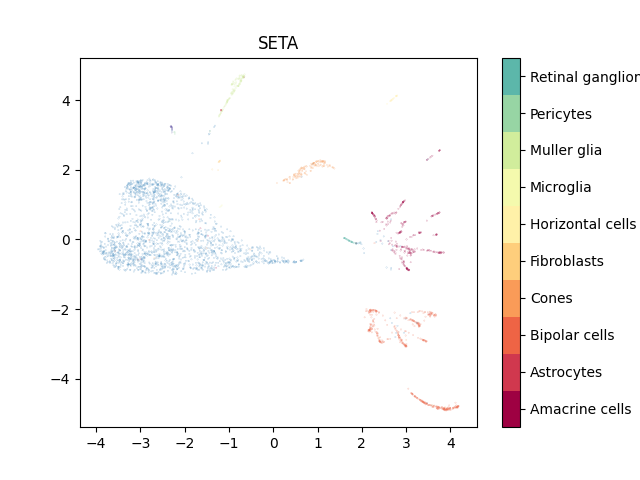

(3008, 2)


<IPython.core.display.Javascript object>


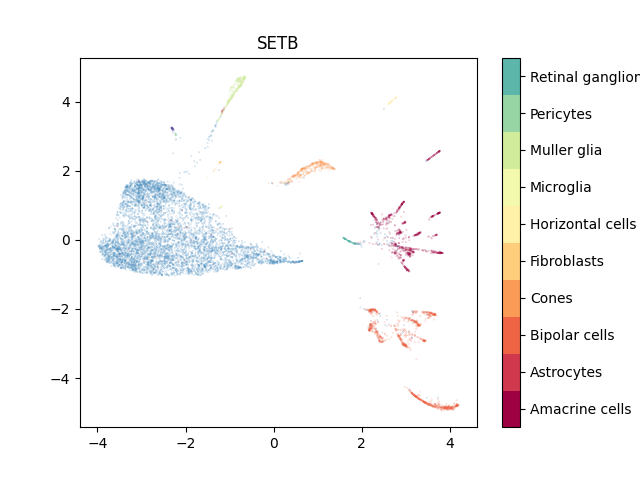

<IPython.core.display.Javascript object>


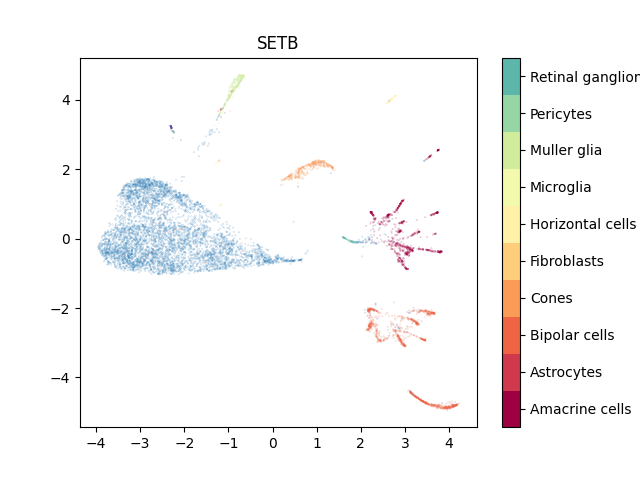

<IPython.core.display.Javascript object>


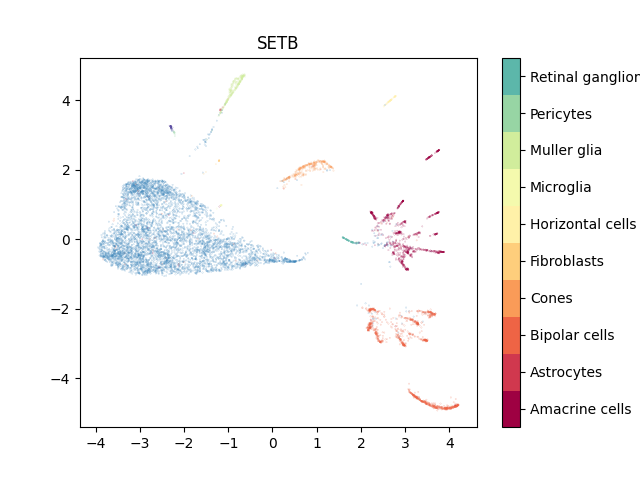

<IPython.core.display.Javascript object>


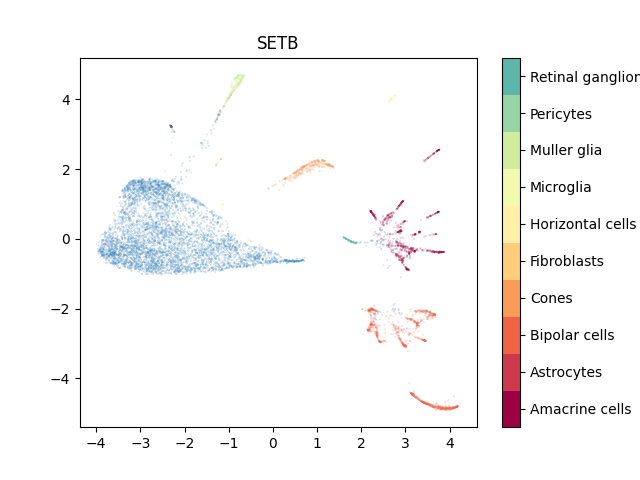

<IPython.core.display.Javascript object>


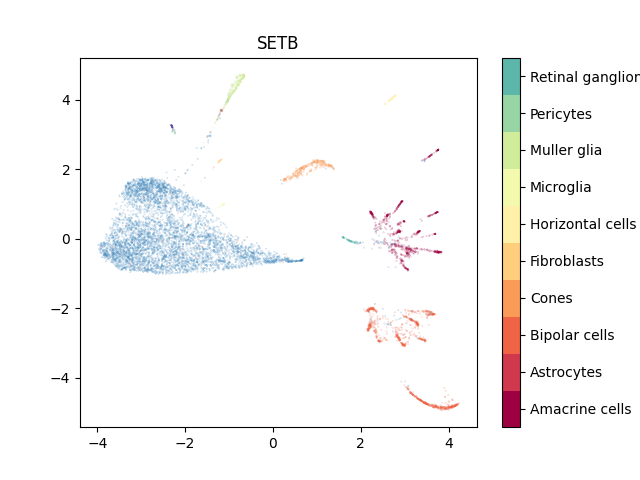

In [16]:
%matplotlib notebook

plt.figure()
plt.title('SETA')
print(embA.shape)
plt.scatter(embA[:,0], embA[:,1], c=y_SETA, s=0.01, cmap='Spectral')
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)

for i in range(n_SET):

    plt.figure()
    plt.title('SETB')
    embB = emb_sets[i]
    y_embB = y_SETS[i]
    plt.scatter(embB[:,0], embB[:,1], c=y_embB, s=0.01, cmap='Spectral')
    cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
    cbar.set_ticks(np.arange(10))
    cbar.set_ticklabels(classes)




In [17]:
emb_sets_tuned = np.array(emb_sets)

with open('MACOSKO_Aligned_NE_5_SETS_3000_11400.npy', 'wb') as f:
    np.save(f, embA)
    np.save(f, emb_sets_tuned)